In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

### **读入数据**
#### 选择ctr-in-advertisement作为实验数据
#### 其中Ad_Click_prediciton_train(1).csv作为训练集，Ad_Click_prediciton_test.csv作为测试集

In [2]:
df1=pd.read_csv("../input/ctr-in-advertisement/Ad_click_prediction_train (1).csv",encoding='utf-8')
df2=pd.read_csv("../input/ctr-in-advertisement/Ad_Click_prediciton_test.csv",encoding='utf-8')
df2['is_click']=1

In [3]:
def PreProcess(df):
    ls=[]
    for i in range(len(df)):
        ls.append(float(df.loc[i,'DateTime'][9]))
    df['day']=ls
    df['product_category_2'] = df['product_category_2'].fillna(0.0)
    mean_index=df['city_development_index'].mean()
    df['city_development_index'] = df['city_development_index'].fillna(mean_index)
    df=df.dropna()
    return df

In [4]:
def OneHotEncoder(df):
    col=['product', 'campaign_id','webpage_id', 'product_category_1', 'product_category_2','user_group_id', 'gender']
    df = pd.get_dummies(df,columns=col)
    df=df.iloc[:,3:]
    return df

### **数据处理**
#### 首先进行DateTime属性的提取关键值，并用各属性平均值来替换缺失值；
#### 之后对于离散值进行独热处理

In [5]:
df1=PreProcess(df1)
df2=PreProcess(df2)
df=pd.concat([df1,df2],axis=0,ignore_index=True)
df=OneHotEncoder(df)
df1=df.iloc[0:df1.shape[0],:]
df2=df.iloc[df1.shape[0]:df1.shape[0]+df2.shape[0],:]

In [6]:
Y_train=df1['is_click'].values.T
df1=df1.drop(['is_click'],axis=1)
X_train=df1.values.T

In [7]:
Y_test=df2['is_click'].values.T
df2=df2.drop(['is_click'],axis=1)
X_test=df2.values.T

In [8]:
type(Y_train)

numpy.ndarray

### **1.sigmod函数**

In [9]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

### **2.前向传播与反向传播**

In [10]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cross_intropy = -(np.dot(Y, np.log(A.T)) + np.dot(np.log(1 - A), (1 - Y).T)) / m
    # 反向传播
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m
    # 降维
    cross_intropy = np.squeeze(cross_intropy)
    grads = {"dw": dw,"db": db}
    return grads, cross_intropy


### **3.预测函数**

In [11]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    Y_prediction_bin = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    # 计算输出值
    A = sigmoid(np.dot(w.T, X) + b)
    Y_prediction = A
    # 将结果离散化
    for i in range(m):
        if A[0][i]>0.5:
            A[0][i]=1
        else:
            A[0][i]=0
    Y_prediction_bindic=A
    return  Y_prediction,Y_prediction_bin


### **4.更新参数w和b,使用梯度下降找出梯度最下点**

In [12]:
def optimizer(w, b, X_train, Y_train, X_test, Y_test, iterations, lr):
    costs = []
    for i in range(iterations):
        #计算梯度和交叉熵
        grads, cross_intropy = propagate(w, b, X_train, Y_train)
        dw = grads["dw"]
        db = grads["db"]
        #更新参数
        w = w - lr * dw
        b = b - lr * db
        # 每20次记录1次交叉熵
        if i % 20 == 0:
            costs.append(cross_intropy)
        #输出交叉熵的变化
        if i % 100 == 0:  # 打印成本值
            print("Iteration {}|Cross Intropy {:.4f}".format(i,cross_intropy))
        params = {"w": w,"b": b}
    return params, costs

### **5.评估函数**

In [13]:
def Recall(Y_predict,Y_real,k,n):
    num=0
    for i in range(k):
        if Y_predict[i]==1 and Y_real[i]==1:
            num+=1
    return num/n

In [14]:
def AP(Y_predict,Y_real,k,n):
    sum_ap=r=0
    for i in range(k):
        if Y_predict[i]==1 and Y_real[i]==1:
            r+=1
            sum_ap+=r/(i+1)
    return sum_ap/(max(k,n))
def MAP(Y_predict,Y_real,k,n):
    m=n//3
    ap1=AP(Y_predict[0:m],Y_real[0:m],k,m)
    ap2=AP(Y_predict[m:2*m],Y_real[m:2*m],k,m)
    ap3=AP(Y_predict[2*m:3*m],Y_real[2*m:3*m],k,m)
    return (ap1+ap2+ap3)/3
    

In [15]:
def DCG(Y_predict,Y_real,k):
    sum_dcg=0
    for i in range(k):
        if Y_predict[i]==1 and Y_real[i]==1:
            sum_dcg+=1/math.log(i+2,2)
    return sum_dcg
def IDCG(Y_predict,Y_real,k):
    sum_idcg=0
    for i in range(k):
        sum_idcg+=1/math.log(i+2,2)
    return sum_idcg
def nDCG(Y_predict,Y_real,k):
    return DCG(Y_predict,Y_real,k)/IDCG(Y_predict,Y_real,k)

In [16]:
def evaluate(Y_predict,Y_real):
    Y_predict=np.squeeze(Y_predict)
    n=len(Y_real)
    #Accu 
    print("Accu: {} %".format(1 - np.mean(np.abs(Y_predict - Y_real))))
    #Recall@1~20
    for i in range(20):
        k=i+1
        r=Recall(Y_predict,Y_real,k,n)
        print('Recall@{}: {}'.format(k,r))
    #MAP@5
    map5=MAP(Y_predict,Y_real,5,n)
    print('MAP@{}: {}'.format(5,map5))
    #MAP@10
    map10=MAP(Y_predict,Y_real,10,n)
    print('MAP@{}: {}'.format(10,map10))
    #nDCG@5
    ndcg5=nDCG(Y_predict,Y_real,5)
    print('nDCG@{}: {}'.format(5,ndcg5))
    #nDCG@10
    ndcg10=nDCG(Y_predict,Y_real,10)
    print('nDCG@{}: {}'.format(10,ndcg10))

### **6.建立整个预测模型，并输出acc的变化**

In [17]:
def model(X_train, Y_train, X_test, Y_test, iterations, lr):
    #初始化参数
    dim = X_train.shape[0]
    w = np.zeros((dim, 1))
    b = 0
    #训练得到最终参数
    parameters, costs = optimizer(w, b, X_train, Y_train, X_test, Y_test, iterations, lr)
    w = parameters["w"]
    b = parameters["b"]
    # 训练集的预测结果
    Y_prediction_train,Y_prediction_train_bin = predict(w, b, X_train)
    # 测试集的预测结果
    Y_prediction_test,Y_prediction_test_bin = predict(w, b, X_test)
    # 评估函数
    print('----------train----------')
    evaluate(Y_prediction_train_bin,Y_train)
    print('----------test----------')
    evaluate(Y_prediction_test_bin,Y_test)
    model = {"lr" : lr,"iterations": iterations,"costs": costs,"w" : w,"b" : b}
    return model

### **基于数据集进行测试**

In [18]:
test = model(X_train, Y_train, X_test, Y_test, iterations = 2000, lr = 0.01)
print(str(test))

Iteration 0|Cross Intropy 0.6931
Iteration 100|Cross Intropy 0.2514
Iteration 200|Cross Intropy 0.2507
Iteration 300|Cross Intropy 0.2503
Iteration 400|Cross Intropy 0.2499
Iteration 500|Cross Intropy 0.2496
Iteration 600|Cross Intropy 0.2494
Iteration 700|Cross Intropy 0.2492
Iteration 800|Cross Intropy 0.2490
Iteration 900|Cross Intropy 0.2488
Iteration 1000|Cross Intropy 0.2486
Iteration 1100|Cross Intropy 0.2485
Iteration 1200|Cross Intropy 0.2484
Iteration 1300|Cross Intropy 0.2483
Iteration 1400|Cross Intropy 0.2482
Iteration 1500|Cross Intropy 0.2481
Iteration 1600|Cross Intropy 0.2480
Iteration 1700|Cross Intropy 0.2479
Iteration 1800|Cross Intropy 0.2479
Iteration 1900|Cross Intropy 0.2478
----------train----------
Accu: 0.9324634646150528 %
Recall@1: 0.0
Recall@2: 0.0
Recall@3: 0.0
Recall@4: 0.0
Recall@5: 0.0
Recall@6: 0.0
Recall@7: 0.0
Recall@8: 0.0
Recall@9: 0.0
Recall@10: 0.0
Recall@11: 0.0
Recall@12: 0.0
Recall@13: 0.0
Recall@14: 0.0
Recall@15: 0.0
Recall@16: 0.0
Recall@1

### **绘制交叉熵变化曲线**

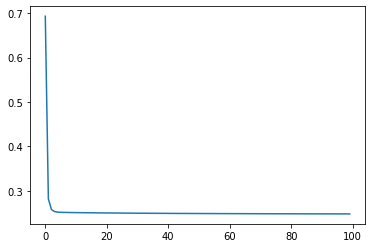

In [19]:
plt.plot(test['costs'])